# Problem Statement
Construct a linear regression model that can generate predicted SalePrice from test.csv with lowest RMSE possible, through EDA, feature engineering and feature selection. 

# Executive Summary

- Understanding of the different variables in the dataset was gained through reading the data dictionary on http://jse.amstat.org/v19n3/decock/DataDocumentation.txt


- Data cleaning and preliminary feature engineering was done on the train.csv file 
    - Conversion of NaN values in categorical variables to 'None' or 0
    - Dropping of features which had relatively weak correlation to SalePrice
    - Combination of the separate features related to size of the house into a single variable Total_Living_SF
    - Dropping of true outliers as suggested from http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
    - Dropping of variables with multicollinearity to certain features in the dataset


- Splitting of train.csv to a training set and testing set


- EDA and continued feature engineering
    - EDA on target variable (SalePrice)
    - Feature engineering: Median (target) encoding of categorical variables
    - Heatmap to plot correlation btw. the different features to SalePrice
    - Scatterplot of the 6 strongest correlated features to SalePrice
    
    
- Feature selection for modelling
    - The 5 strongest positively correlated features + 1 strongest negatively correlated features were chosen
    
    
- Model Construction
    - Cross-validation done on training set using Linear Regression, Ridge and Lasso to choose which to use
        - Linear Regression chosen as very similar performance between the 3
    - Baseline model created with 'Total_Living_SF' as it was the most strongly correlated (non-interacting) feature
    - Subsequently more models were created using more predictors
        - Adjusted R^2 score was used to see if there is actual improvement
    - A new poly-features dataframe was created using the 6 predictor variables + combination of interactions
        - Cross-validation done on this new dataframe


- Model Evaluation on testing set
    - Model 6 (poly-features) chosen as best model
    - Linear Regression, Ridge and Lasso used to see which is the best model on the validating set (testing_set df)
    - Turned out Linear Regression was able to generalize to the unseen testing set
    
    
- Selected model utilized to predict SalePrice using test.csv
    - Kaggle RMSE score of 26181

# Data Dictionary

Due to the extensive number of features in the dataset, only those that were used in the final model will be included in the data dictionary.

|Feature|Type|Usage in model|Description|
|-------|----|-----|-----------|
|SalePrice|*float*|Target Variable|The target variable; the price of the house at sale|
|Total_Living_SF|*float*|Predictor Variable|Addition of all features related to size of the house, in sq ft.|  
|Neighborhood_MedianPrice|*float*|Predictor Variable|Median price of houses within that neighborhood|
|Overall Qual|*int*, *ordinal*|Predictor Variable|The rating (1-10), 10 being the best, of the overall material & finish of the house|
|Overall Cond|*int*, *ordinal*|Predictor Variable|The rating (1-10), 10 being the best, of the overall condition of the house|
|Garage Area|*float*|Predictor Variable|Size of the garage in sq ft.|
|Year Built|*int*|Predictor Variable|The year the house was built


- Rest of the features can be found on:  http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# Contents:
- [Importing Data & Data Cleaning](#Importing-Data-&-Data-Cleaning)
    - [Feature Engineering](#Feature-Engineering:)
- [Splitting train dataset into the training set + testing set](#Splitting-train-dataset-into-the-training-set-+-testing-set)
- [Exploratory Data Analysis and Continued Feature Engineering](#Exploratory-Data-Analysis-&-Continued-Feature-Engineering)
    - [Median Encoding of categorical variables](#Feature-Engineering:-Median-Target-encoding)
    - [Heatmap](#--Heatmap)
- [Pre-processing (Scaling)](#Pre-processing)
- [Cross-validation on training set](#Cross-Validation)
- [Model Construction](#Model-Construction)
- [Model Evaluation on Testing set](#Model-Evaluation-on-testing-set)
- [Prediction on test.csv using selected model](#Model-Prediction-on-actual-test.csv)

In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

# Importing Data & Data Cleaning

In [2]:
# Import train & test dataset
# Clearning and feature engineering will be done on both simultaneously 
# Columns in the train dataset must be reflected in the test dataset
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 1000)
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# Get rid of whitespace before and after the column names
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2.198000e+03,2930.0
PID,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,9.071801e+08,924152030.0
MS SubClass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,7.000000e+01,190.0
Lot Frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,8.000000e+01,313.0
Lot Area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,1.151350e+04,159000.0
Overall Qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.000000e+00,10.0
Overall Cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.000000e+00,9.0
Year Built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2.001000e+03,2010.0
Year Remod/Add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2.004000e+03,2010.0
Mas Vnr Area,2029.0,9.969591e+01,1.749631e+02,0.0,0.0,0.0,1.610000e+02,1600.0


- *Some features (bedrooms/bathrooms etc) have min val = 0 which is a bit surprising*

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

- *Some features have large numbers of null values*
- *There are 81 features*
- *There are 2051 observations*
- *Datatypes consists of: int, float, str*

### Feature Engineering:


- Preliminary feature engineering where extensive EDA was not necessary.

#### *- Identify features that can be deleted:*

In [6]:
# Drop ID, PID, Garage Cars
# Id column clearly has no correlation with the value (from the data dictionary it is just the observation number)
# PID is related to location, which is given by other variables like Neighborhood (that are easier to interpret) already.
# PID is a nominal variable as well, with no order to it.
# Garage Cars is represented by Garage Area already
 
train.drop(labels=['Id', 'PID', 'Garage Cars'], axis=1, inplace=True)
test.drop(labels=['PID', 'Garage Cars'], axis=1, inplace=True) # Don't drop Id col in test as it is needed later

In [7]:
# Pool area correlation with 'SalePrice'
print('Pool area correlation to SalePrice:', train['Pool Area'].corr(train['SalePrice']))

Pool area correlation to SalePrice: 0.023106317157886826


In [8]:
# Pool Area can be dropped as very low correlation to SalePrice
# Pool QC is a categorical variable dependent on the presence of a pool in the property -- therefore can be dropped as well

train.drop(labels=['Pool Area', 'Pool QC'], axis=1, inplace=True)
test.drop(labels=['Pool Area', 'Pool QC'], axis=1, inplace=True)

In [9]:
# Drop Garage Qual, Exter Qual, Bsmt Qual, Kitchen Qual
# There is a variable for Overall Qual already
# The Overall Qual rating is just the 4 quality assessments added together

train.drop(labels=['Garage Qual', 'Exter Qual', 'Bsmt Qual', 'Kitchen Qual'], axis=1, inplace=True)
test.drop(labels=['Garage Qual', 'Exter Qual', 'Bsmt Qual', 'Kitchen Qual'], axis=1, inplace=True)

#### *- Identify rows that can be deleted:*

In [10]:
# From http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
# Remove any rows where 'Gr Liv Area' > 4000
train[train['Gr Liv Area'] > 4000]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Cond,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Area,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,TA,PConc,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,12,Typ,3,Gd,Attchd,2008.0,Fin,1418.0,TA,Y,214,292,0,0,0,NaN,NaN,0,1,2008,New,160000
1885,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,TA,PConc,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,15,Typ,2,Gd,Attchd,2008.0,Fin,1154.0,TA,Y,546,484,0,0,0,NaN,Elev,17000,10,2007,New,183850


In [11]:
# Drop the 2 rows which has 'Gr Liv Area' > 4000
train.drop(train[train['Gr Liv Area'] > 4000].index, inplace=True)

#### - *Combining features:*

In [12]:
# Combine all variables related to size of house to get Total_Living_SF
SF_lst = ['BsmtFin SF 1', 'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF', 
                   'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                   'Screen Porch', '3Ssn Porch', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF']

# Total Bsmt SF is BsmtFin SF 1 & BsmtFin SF 2 & Bsmt Unf SF added together
# Therefore, BsmtFin SF 1 & BsmtFin SF 2 & Bsmt Unf SF will not be part of the summation for Total_Living_SF
train['Total_Living_SF'] = (train['Total Bsmt SF'] + train['Gr Liv Area'] + train['Wood Deck SF'] 
                            + train['Open Porch SF'] + train['3Ssn Porch'] + train['Enclosed Porch'] + train['Low Qual Fin SF']
                            + train['Screen Porch'])

test['Total_Living_SF'] = (test['Total Bsmt SF'] + test['Gr Liv Area'] + test['Wood Deck SF'] 
                            + test['Open Porch SF'] + test['3Ssn Porch'] + test['Enclosed Porch'] + test['Low Qual Fin SF']
                            + test['Screen Porch'])

# Drop the variables used for Total_Living_SF 
train.drop(labels=SF_lst, axis=1, inplace=True)
test.drop(labels=SF_lst, axis=1, inplace=True)

In [13]:
# Explore features that are intuitively related to the size of the house
# Drop variables that have multicollinearity with Total_Living_SF 
# Variables that have low correlation to SalePrice should also be dropped
lst = ['Bsmt Full Bath', 'Bsmt Half Bath', 'TotRms AbvGrd', 'Half Bath', 'Full Bath',
      'Kitchen AbvGr', 'Bedroom AbvGr']

# Print correlation of the variables in lst to SalePrice
print(train[lst+['Total_Living_SF', 'SalePrice']].corr()[['Total_Living_SF', 'SalePrice']])

                 Total_Living_SF  SalePrice
Bsmt Full Bath          0.220932   0.284763
Bsmt Half Bath         -0.042921  -0.045571
TotRms AbvGrd           0.653481   0.509775
Half Bath               0.237911   0.283372
Full Bath               0.567107   0.538225
Kitchen AbvGr           0.009512  -0.125472
Bedroom AbvGr           0.346654   0.137145
Total_Living_SF         1.000000   0.821856
SalePrice               0.821856   1.000000


In [14]:
# Drop variables in lst as they either have high correlation with Total_Living_SF or low correlation with SalePrice
train.drop(labels=lst, axis=1, inplace=True)
test.drop(labels=lst, axis=1, inplace=True)

#### *- Dealing with Null Values:*

In [15]:
# sort by columns with most null values
train.isnull().sum().sort_values(ascending=False).head(30)

Misc Feature       1985
Alley              1909
Fence              1649
Fireplace Qu       1000
Lot Frontage        330
Garage Finish       114
Garage Yr Blt       114
Garage Cond         114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
BsmtFin Type 1       55
Bsmt Cond            55
Mas Vnr Type         22
Mas Vnr Area         22
Garage Area           1
Total_Living_SF       1
Bldg Type             0
House Style           0
Condition 2           0
Condition 1           0
Overall Qual          0
Land Contour          0
Neighborhood          0
Land Slope            0
Lot Config            0
Utilities             0
Year Built            0
Lot Shape             0
Street                0
dtype: int64

*- Identify variables where NaN values cannot be removed:*

In [16]:
# List of all the categorical columns with 'NA'/'None' etc. as a category
# These variables have NaN entries, but these entries should be 'None'/0
lst_cols = ['Misc Feature',
            'Alley',
            'Fence',
            'Fireplace Qu',
            'Garage Finish',
            'Garage Cond',
            'Garage Yr Blt',
            'Garage Type',
            'Bsmt Exposure',
            'BsmtFin Type 2',
            'BsmtFin Type 1',
            'Bsmt Cond',
            'Mas Vnr Type',
            'Lot Frontage']

In [17]:
# Define fn which converts NaN values to 'None' string
def nan_converter(df, lst_cols): # Define fn which converts NaN values to 'None' string
    for col in lst_cols:
        if df[col].dtypes == 'O': # if dtype is string, then replace NaN with 'None'
            df[col].fillna('None', inplace=True)
        else:
            df[col].fillna(0, inplace=True) # otherwise, replace with int(0)

In [18]:
# Call the nan_converter fn
nan_converter(train, lst_cols)
nan_converter(test, lst_cols)

In [19]:
# Find any other columns with null values
train.isnull().sum().sort_values(ascending=False).head(30)

Mas Vnr Area       22
Total_Living_SF     1
Garage Area         1
Condition 2         0
Exterior 2nd        0
Exterior 1st        0
Roof Matl           0
Roof Style          0
Year Remod/Add      0
Year Built          0
Overall Cond        0
Overall Qual        0
House Style         0
Bldg Type           0
Neighborhood        0
Condition 1         0
Land Slope          0
Lot Config          0
Utilities           0
Land Contour        0
Lot Shape           0
Alley               0
Street              0
Lot Area            0
Lot Frontage        0
MS Zoning           0
Mas Vnr Type        0
Exter Cond          0
SalePrice           0
Garage Type         0
dtype: int64

In [20]:
# For remaining NaN values, drop the whole row
# They are not categorical variables that have 'None' categories
# The number of dropped rows is relatively small (we would still have 2000+ observations), therefore not much of an impact
train.dropna(inplace=True)
train.shape

(2025, 53)

# Splitting train dataset into the training set + testing set

- The train dataframe will be split into a training set and a testing set to enable model evaluation
- This was to ensure that the model would not be overfitted to an unacceptable degree before using it to predict 

In [21]:
# Split training df to a training set and testing set
training_set, testing_set = train_test_split(train, test_size=0.2, random_state=42)

In [22]:
training_set.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Cond,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Area,Garage Cond,Paved Drive,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Total_Living_SF
1847,45,RM,50.0,6000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,7,1926,2004,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,PConc,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,Typ,0,None,Detchd,1926.0,Unf,180.0,TA,Y,None,None,0,1,2009,WD,119000,1893.0
689,190,RL,70.0,7000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,2Story,5,7,1910,1991,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,CBlock,TA,Gd,GLQ,Unf,GasA,TA,Y,SBrkr,Typ,0,None,None,0.0,None,0.0,None,N,None,None,0,1,2008,WD,107500,2697.0
1795,120,RL,40.0,3876,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Greens,Norm,Norm,Twnhs,1Story,8,5,1978,1978,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,CBlock,TA,Gd,GLQ,Rec,GasA,TA,Y,SBrkr,Typ,1,TA,Attchd,1978.0,Fin,484.0,TA,Y,None,None,0,7,2006,WD,170000,2645.0
1318,70,RM,60.0,10800,Pave,Grvl,Reg,Bnk,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,8,1890,1998,Gable,CompShg,Wd Sdng,VinylSd,None,0.0,Gd,BrkTil,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Typ,0,None,Detchd,1996.0,Unf,704.0,TA,P,None,None,0,7,2007,WD,159500,3463.0
1774,20,RL,60.0,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,3,1950,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,CBlock,TA,No,LwQ,Unf,GasA,Fa,Y,FuseA,Min2,1,TA,Attchd,1950.0,Unf,357.0,TA,Y,None,None,0,11,2007,WD,102000,2273.0


# Exploratory Data Analysis & Continued Feature Engineering

In [23]:
training_set.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Fireplaces,Garage Yr Blt,Garage Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Total_Living_SF
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,57.185185,57.358025,9933.729630,6.109877,5.560494,1972.093827,1984.385802,100.614198,0.580864,1874.827160,472.024691,42.774074,6.204321,2007.785185,180775.783333,2717.614198
std,43.223027,32.824296,6795.798316,1.419541,1.096085,30.041681,20.904056,174.842606,0.626966,441.987435,213.998922,438.303435,2.701013,1.312091,79126.372910,838.841193
min,20.000000,0.000000,1470.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,334.000000
25%,20.000000,43.000000,7423.750000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,1958.000000,313.000000,0.000000,4.000000,2007.000000,129975.000000,2132.000000
50%,50.000000,63.000000,9362.000000,6.000000,5.000000,1975.000000,1993.000000,0.000000,1.000000,1978.000000,480.000000,0.000000,6.000000,2008.000000,163000.000000,2640.000000
75%,70.000000,78.000000,11494.000000,7.000000,6.000000,2001.000000,2004.000000,163.250000,1.000000,2001.000000,576.000000,0.000000,8.000000,2009.000000,213000.000000,3186.250000
max,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,3.000000,2010.000000,1356.000000,12500.000000,12.000000,2010.000000,611657.000000,7058.000000


- Training_set has 1620 observations
- Preliminary observation of the statistics for each numerical col seems to show that they are within sensible ranges

### Explore SalePrice (Target Variable)

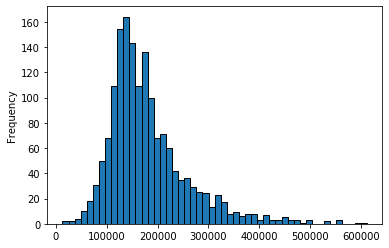

In [24]:
# Plot histogram of SalePrice
plt.rcParams["patch.force_edgecolor"] = True
training_set['SalePrice'].plot(kind='hist', bins=50)

- The SalePrice is positively skewed and not normally distributed.
- This suggests that there is high variance in the price for high end houses.
- Inference of population statistics or hypothesis testing for this target variable will be inaccurate
- However, prediction can still be done as the normality requirement applies to the distribution of the errors of the predicted values and not the distribution of the target variable itself
- Since the distribution is skewed, median target encoding will be used (instead of mean) for categorical variables to ensure that the model is more resistant to overfitting due to outliers.

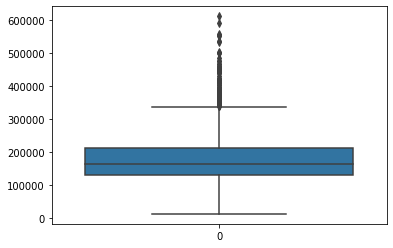

In [25]:
# Plot a boxplot of the target variable 
ax = sns.boxplot(data=training_set['SalePrice'])
#ax = sns.swarmplot(data=train['SalePrice'], color='grey') #Swarmplot was disabled because it cluttered up the boxplot

- Boxplot again reinforces the idea that there are a number of outliers at the higher end of SalePrice.

### Explore Correlation to SalePrice

#### Feature Engineering: Median Target encoding
- Groupby the categories and calculate the median SalePrice for each category in the categorical variables (median encoding)
- In effect, this achieves a similar purpose as using one-hot encoding, but does not clutter up the dataframe
- However, overfitting may be an issue (as data leakage can occur), therefore train-test-split of the train dataset was done, in order for a testing set to be available for a sanity check to see if the model can generalize to unseen data
- Neighborhood is selected to focus on as it has one of the strongest correlation to SalePrice

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


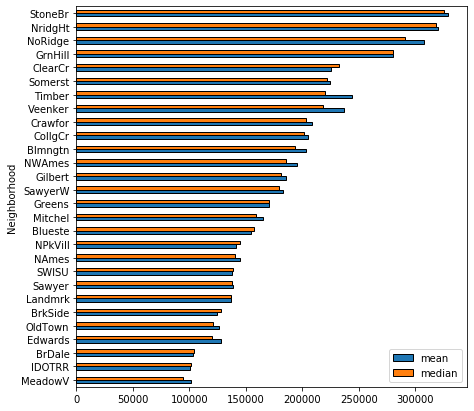

In [26]:
# Location is given by the Neighborhood variable.
# Location should have high correlation with SalePrice.
# Groupby on Neighborhood and find mean price of each neighborhood. 
# Create new column with the mean price corresponding to the neighborhood 'Neighborhood_MeanPrice'

training_set.groupby('Neighborhood')['SalePrice'].agg(['mean', 'median']).sort_values(by='median').plot(kind='barh', figsize=(7,7))
training_set['Neighborhood_MedianPrice'] = training_set['Neighborhood'].map(training_set.groupby('Neighborhood').median()['SalePrice'])

- Prices vary quite a lot by Neighborhood. StoneBr is the most expensive neighborhood, whilst MeadowV is cheapest.
- Shows that the Neighborhood (i.e. location) has strong influence on the SalePrice
- In general, median and mean prices for each neighborhood is within a similar range, suggesting that based on neighborhood alone, the distribution of prices within a certain neighborhood is relatively symmetrical.
    - Noticeable exceptions are Timber and Veenker, as the mean price is quite significantly greater than the median price.

In [27]:
# Assign the median price for each neighborhood to a dict
# This is so that these values can be mapped to the testing set of the train dataset, and also the test dataset
# Subsequently, create a Neighborhood_MedianPrice column in the test dataset with the median prices associated w/ each neighborhood
neighborhood_medianprice_dict = dict(training_set.groupby('Neighborhood').median()['SalePrice'])
testing_set['Neighborhood_MedianPrice'] = testing_set['Neighborhood'].map(lambda x: neighborhood_medianprice_dict[x])
test['Neighborhood_MedianPrice'] = test['Neighborhood'].map(lambda x: neighborhood_medianprice_dict[x])

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
# define fn to groupby all categorical variables with dtype == str, and show mean & median SalePrice

def groupby_categorical_str(df):
    for col in df:
        if (df[col].dtypes == 'O') | (col == 'MS SubClass'):
            df.groupby(col)['SalePrice'].agg(['mean', 'median']).sort_values(by='median').plot(kind='barh')

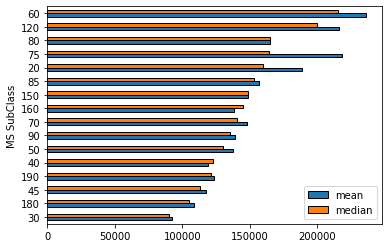

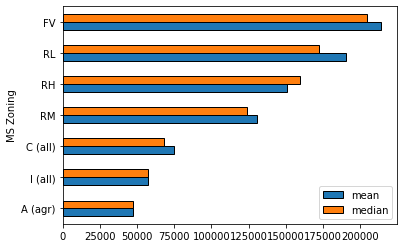

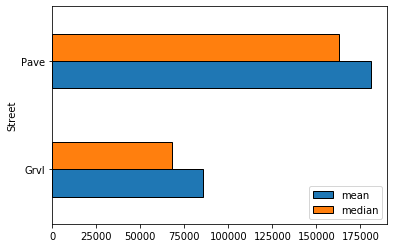

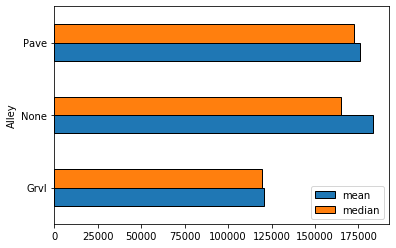

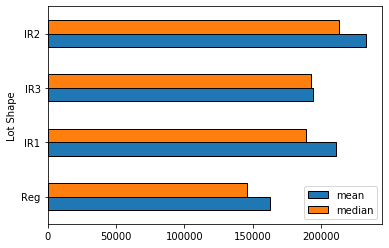

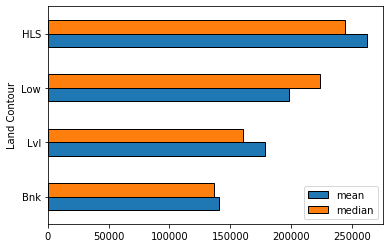

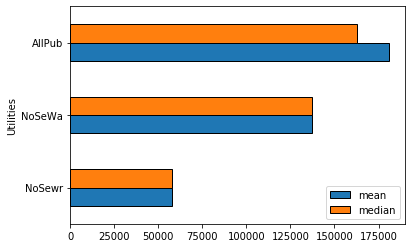

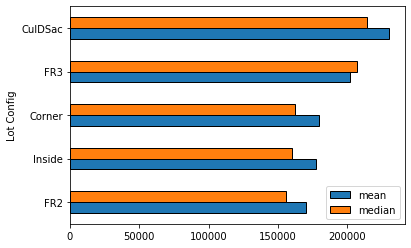

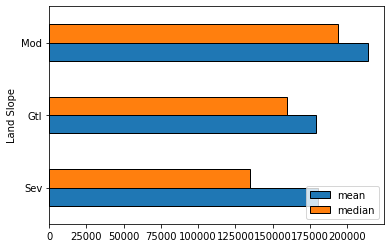

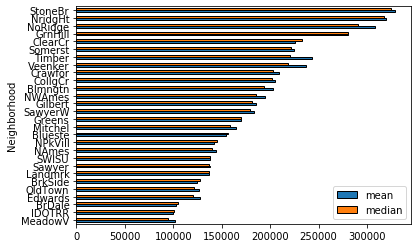

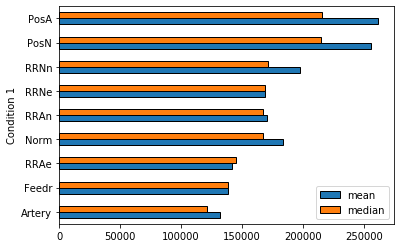

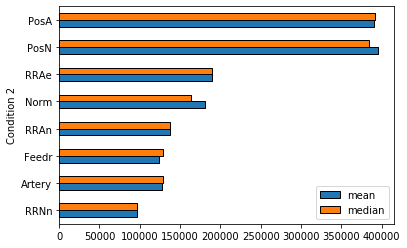

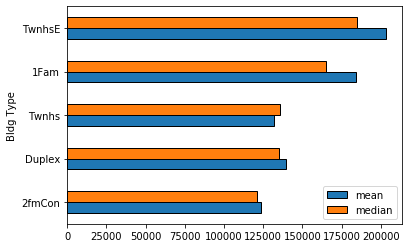

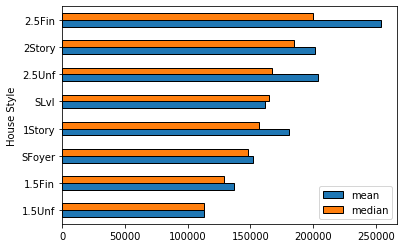

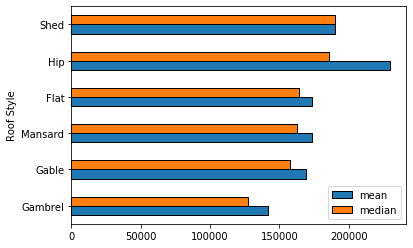

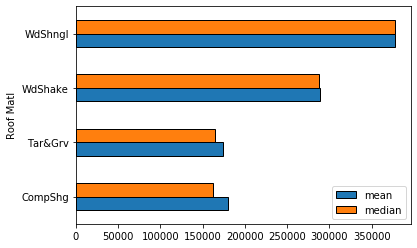

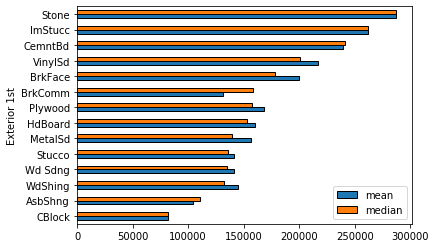

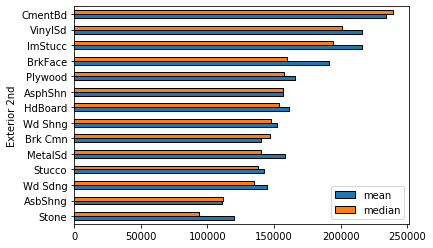

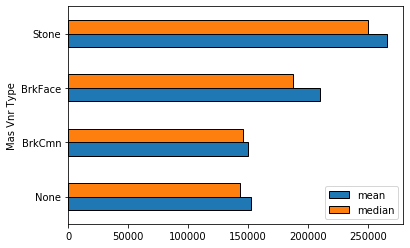

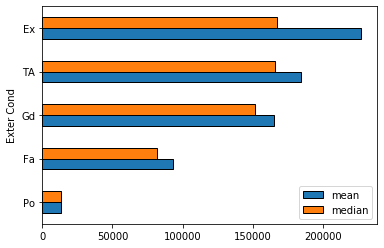

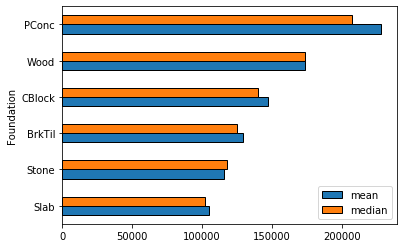

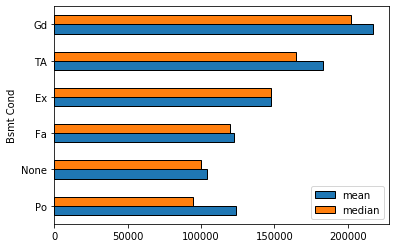

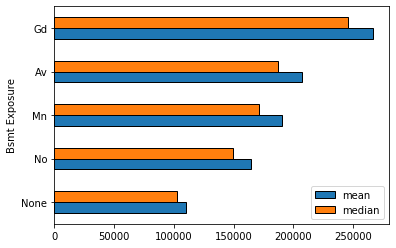

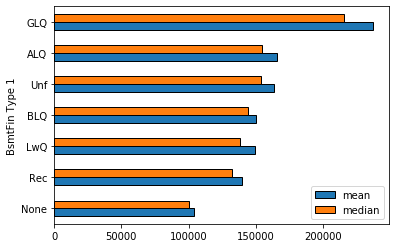

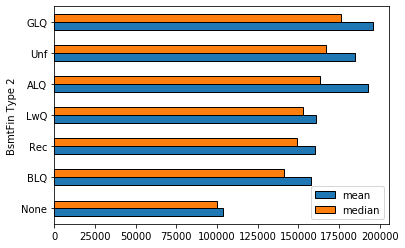

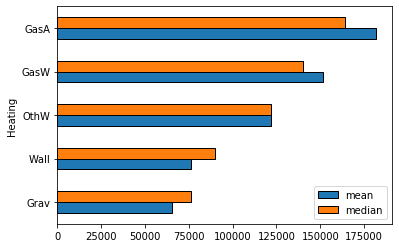

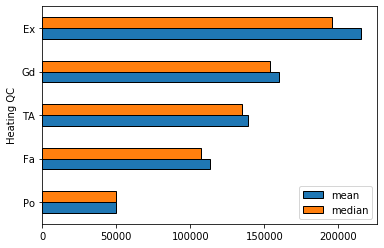

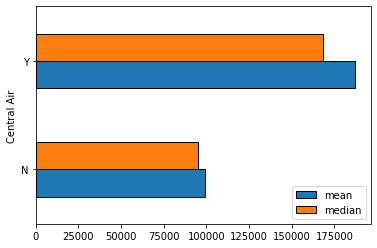

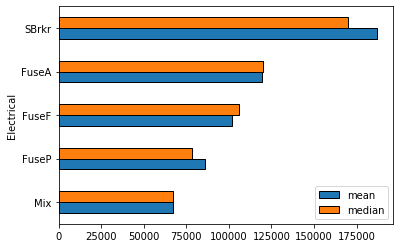

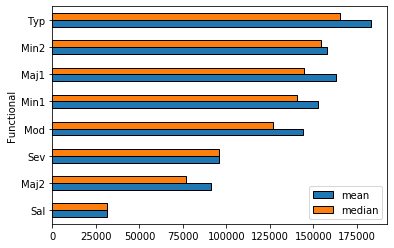

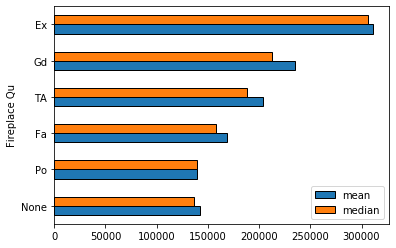

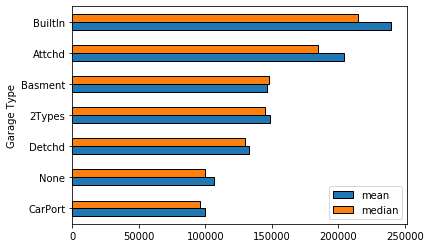

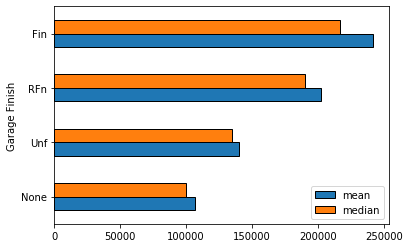

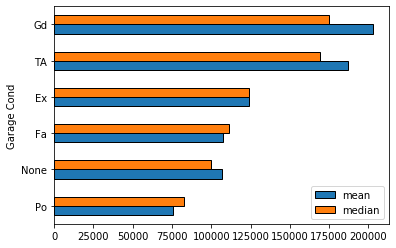

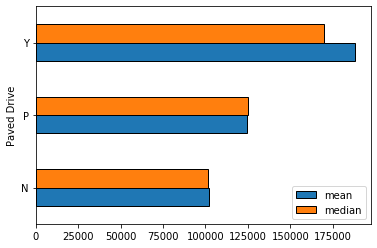

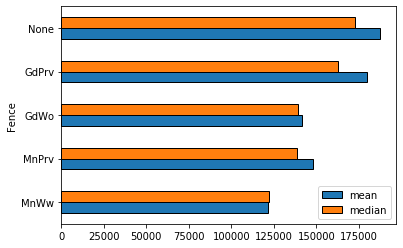

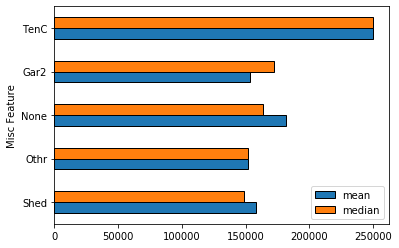

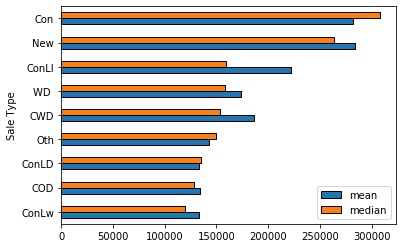

In [29]:
plt.rcParams.update({'figure.max_open_warning': 0}) # prevent the max_open warning from appearing so that window does not get clogged up
groupby_categorical_str(training_set)

In [30]:
# Define a fn which will do the same thing as the fn above, but instead of plotting out the stats it will create new columns
# Created columns will be the median encoding of the respective feature
def new_target_encode_col(df=training_set):
    new_cols = []
    for col in df:
        if (df[col].dtypes == 'O') | (col == 'MS SubClass') & (col != 'Neighborhood'): # Only columns with dtype as string or MS SubClass
            medianprice_dict = dict(df.groupby(col).median()['SalePrice']) # Store the meanprice values in a dict
            df[col+'_MedianPrice'] = df[col].map(df.groupby(col)['SalePrice'].median())
            # Create an identical column in test dataframe to median encode the feature
            # Some categories in the testing_set and test dataset might not be in the train dataset 
            # For those categories, impute with the median medianprice instead
            testing_set[col+'_MedianPrice'] = testing_set[col].map(lambda x: medianprice_dict[x] if x in medianprice_dict.keys() 
                                                   else np.median(list(medianprice_dict.values())))

            test[col+'_MedianPrice'] = test[col].map(lambda x: medianprice_dict[x] if x in medianprice_dict.keys() 
                                                   else np.median(list(medianprice_dict.values())))


In [31]:
new_target_encode_col()

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


#### - *Interactions:*

In [32]:
# This interaction column is created in order to be used in Model 5
training_set['Interaction_Overall Qual_Total Living SF'] = training_set['Overall Qual'] * training_set['Total_Living_SF']
testing_set['Interaction_Overall Qual_Total Living SF'] = testing_set['Overall Qual'] * testing_set['Total_Living_SF']
test['Interaction_Overall Qual_Total Living SF'] = test['Overall Qual'] * test['Total_Living_SF']

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### - *Heatmap*

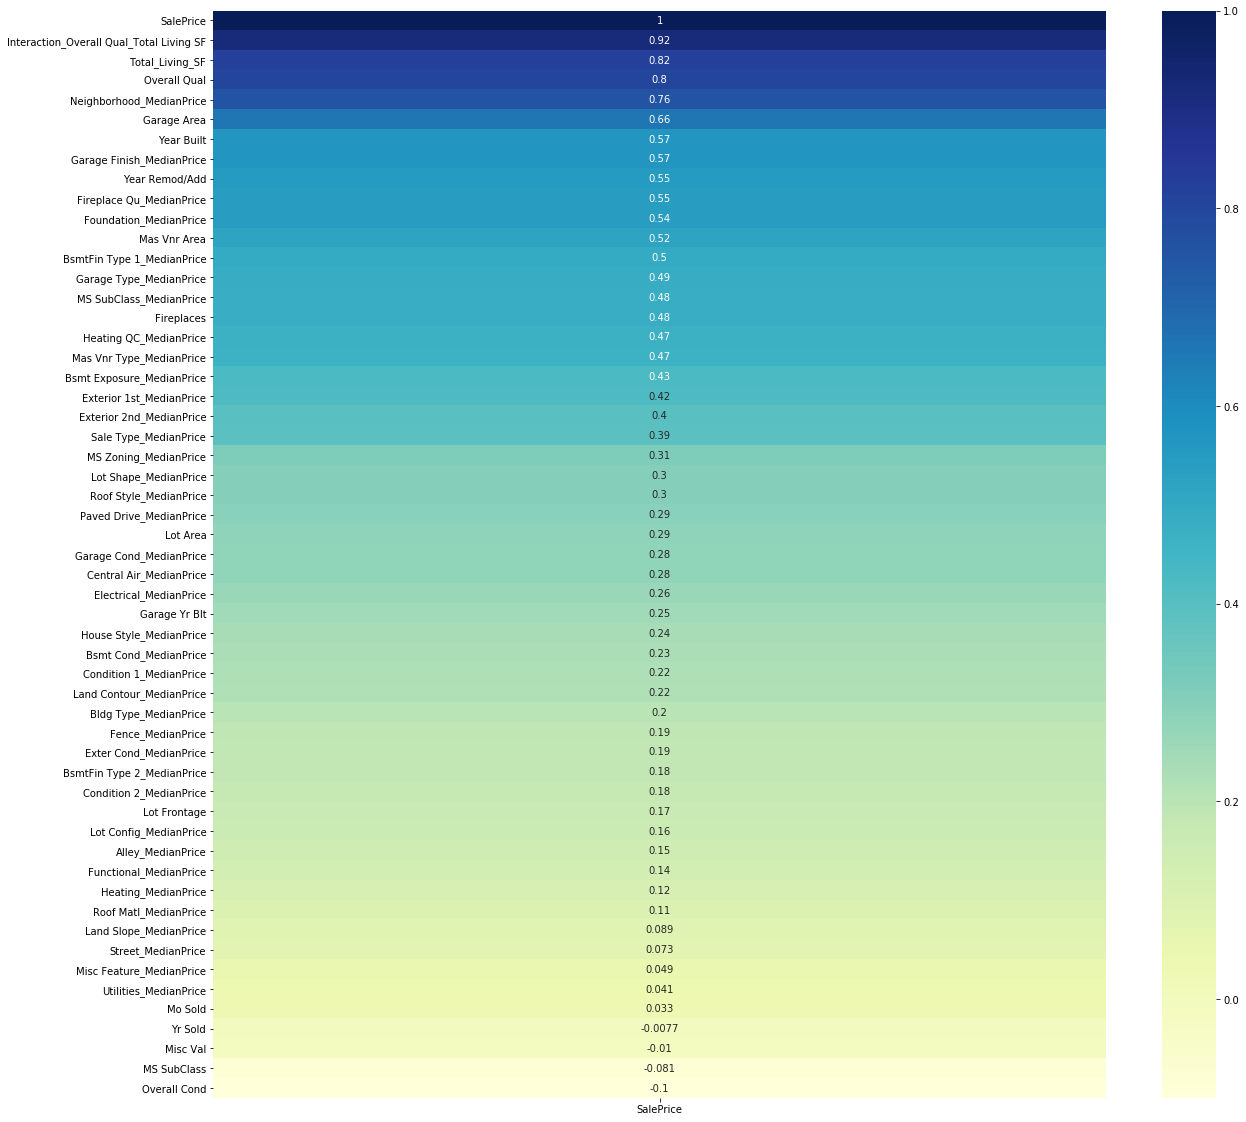

In [33]:
# Plot seaborn heatmap to get a general idea of the correlations of numerical variables to SalePrice
training_set_corr = training_set.corr()
plt.figure(figsize=(20,20))
sns.heatmap(training_set_corr[['SalePrice']].sort_values(by=['SalePrice'], ascending=False),
           annot=True, cmap='YlGnBu')

- From the heatmap, it can be seen that the strongest correlated predictors to SalePrice (excluding interaction predictors) are:
    - Positive: Overall Qual, Total_Living_SF, Neighborhood_MeanPrice, Garage Area, Year Built
    - Negative: Overall Cond

## EDA of choice predictor variables

In [34]:
# Scatterplot of each 
# Define fn to subplot the scatterplots

def subplot_scatterplt(dataframe, list_of_plot): 
    nrows = int(np.ceil(len(list_of_plot)/2)) # Makes sure you have enough rows
    # nrows=nrows+1 because of a problem with seaborn regplot subplots, where the last plot is plotted wrongly
    # this problem has been identified: https://github.com/mwaskom/seaborn/issues/1568
    # adding an extra row fixes this problem
    fig, ax = plt.subplots(nrows=nrows+1, ncols=2, figsize=(20,20), sharex=False)
    plt.subplots_adjust(hspace=0.5, wspace=0.3) # ensure there is set spacing between the subplots
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, plot in enumerate(list_of_plot): # Gives us an index value to get into all our lists
        sns.regplot(dataframe[list_of_plot[i][0]], dataframe[list_of_plot[i][1]], dataframe, ax=ax[i], line_kws={'color':"red"}, 
                    scatter_kws={'color':"blue"}) 
        # Set titles, labels, etc here for each subplot
        ax[i].set_title(list_of_plot[i][0] + ' vs. ' + list_of_plot[i][1], size=15)
        ax[i].set_xlabel(list_of_plot[i][0], size=15)
        ax[i].tick_params(axis='both', which='major', labelsize=15)
        ax[i].set_ylabel(list_of_plot[i][1], size=15)        

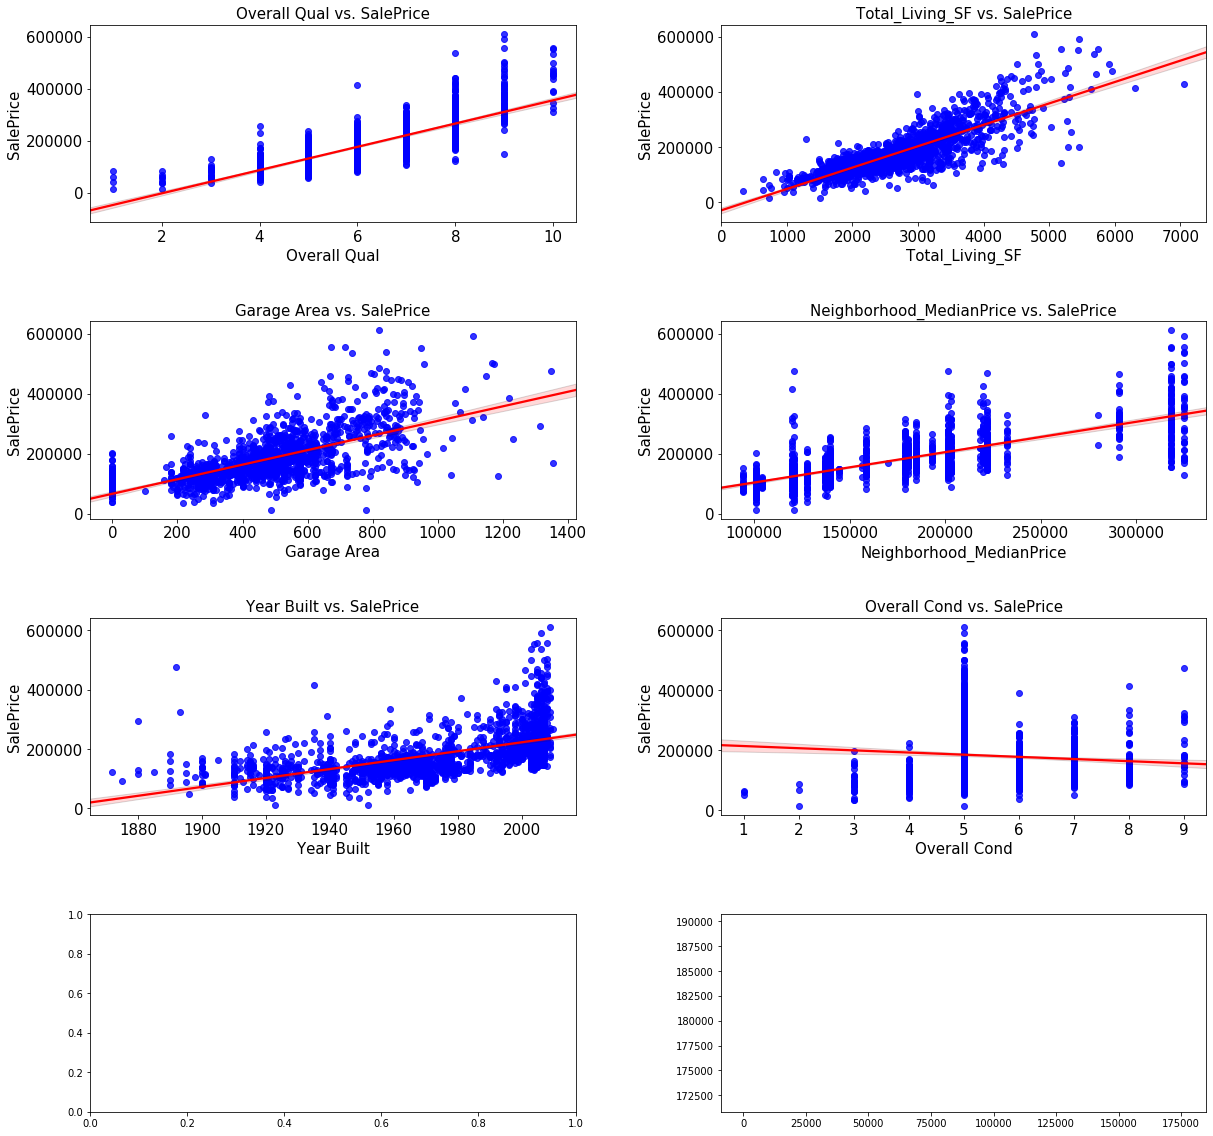

In [35]:
# Predictor variables with strongest correlation were chosen to be plotted against SalePrice
list_of_plot = [['Overall Qual', 'SalePrice'], ['Total_Living_SF', 'SalePrice'], ['Garage Area', 'SalePrice'],
               ['Neighborhood_MedianPrice', 'SalePrice'], ['Year Built', 'SalePrice'], ['Overall Cond', 'SalePrice']]
subplot_scatterplt(training_set, list_of_plot)

- Towards the higher end of the SalePrice range, there is increasing variance.
- This is reflective of real world markets, where high end housing has a wider range of prices.
- It is quite surprising that Overall Cond has -ve correlation with SalePrice
    - Increasing value (1-10) indicated better condition, and should have resulted in higher prices
    - This could be due to the subjective nature of the feature


# Pre-processing

### Scaling

- StandardScaler() could have been used, however the scaling was done manually before I fully understood how to use StandardScaler() and therefore I did not see the need to modify this part.
- Pseudocode to demonstrate that I know how to use StandardScaler() now:
    - Initialize StandardScaler(), e.g. scaler = StandardScaler()
    - run scaler.fit(training_set[[all columns apart from SalePrice]]) --> this will calc. the means and stds of each predictor variable in training_set
    - scale the training_set variables: scaler.transform(training_set.drop(['SalePrice'])
    - scale the testing_set predictor variables: scaler.transform(testing_set.drop(['SalePrice'])
    - scale the test dataframe predictor variables: scaler.transform(test.drop(['SalePrice'])

In [36]:
# Define a fn that will calc the Mean and Standard dev. of each column in the training_set dataframe
# The output is a dictionary {col name: value of the calculated stat}
# This is necessary so that the training_set dataset stats can be used in scaling the testing_set and test.csv variables later

def calc_col_stats(df=training_set):
    col_means = {col: df[col].mean() for col in df if (df[col].dtypes != 'O') and (col != 'SalePrice') and (col != 'Id')}
    col_stds = {col: df[col].std() for col in df if (df[col].dtypes != 'O') and (col != 'SalePrice') and (col != 'Id')}
    
    return col_means, col_stds

In [37]:
# Assign the calculated mean and std from the train dataset to variables mean, std
mean, std = calc_col_stats()
mean, std

({'MS SubClass': 57.18518518518518,
  'Lot Frontage': 57.358024691358025,
  'Lot Area': 9933.72962962963,
  'Overall Qual': 6.109876543209877,
  'Overall Cond': 5.560493827160494,
  'Year Built': 1972.093827160494,
  'Year Remod/Add': 1984.3858024691358,
  'Mas Vnr Area': 100.6141975308642,
  'Fireplaces': 0.5808641975308642,
  'Garage Yr Blt': 1874.8271604938273,
  'Garage Area': 472.0246913580247,
  'Misc Val': 42.77407407407407,
  'Mo Sold': 6.204320987654321,
  'Yr Sold': 2007.7851851851851,
  'Total_Living_SF': 2717.614197530864,
  'Neighborhood_MedianPrice': 176196.60185185185,
  'MS SubClass_MedianPrice': 163183.6901234568,
  'MS Zoning_MedianPrice': 165034.97962962964,
  'Street_MedianPrice': 162647.4537037037,
  'Alley_MedianPrice': 163466.97530864197,
  'Lot Shape_MedianPrice': 162103.07407407407,
  'Land Contour_MedianPrice': 164295.37037037036,
  'Utilities_MedianPrice': 162919.21296296295,
  'Lot Config_MedianPrice': 163738.9814814815,
  'Land Slope_MedianPrice': 161424.07

In [38]:
def scaler(df):
    col_lst = []
    # Get a filtered list of predictor variables that are numerical and not Id or SalePrice
    for col in df:
        if (df[col].dtypes != 'O') and (col != 'SalePrice') and (col != 'Id'):
            col_lst.append(col)
    # Iterate through the list and scale the values in the column using z-score
    # The mean and std are derived from the training_set dataframe
    for col in col_lst:
        df[col] = df[col].map(lambda x: (x - mean[col])/std[col])


In [39]:
# Scale predictor variables in train using z-score
scaler(training_set)

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [40]:
training_set.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Cond,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Area,Garage Cond,Paved Drive,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Total_Living_SF,Neighborhood_MedianPrice,MS SubClass_MedianPrice,MS Zoning_MedianPrice,Street_MedianPrice,Alley_MedianPrice,Lot Shape_MedianPrice,Land Contour_MedianPrice,Utilities_MedianPrice,Lot Config_MedianPrice,Land Slope_MedianPrice,Condition 1_MedianPrice,Condition 2_MedianPrice,Bldg Type_MedianPrice,House Style_MedianPrice,Roof Style_MedianPrice,Roof Matl_MedianPrice,Exterior 1st_MedianPrice,Exterior 2nd_MedianPrice,Mas Vnr Type_MedianPrice,Exter Cond_MedianPrice,Foundation_MedianPrice,Bsmt Cond_MedianPrice,Bsmt Exposure_MedianPrice,BsmtFin Type 1_MedianPrice,BsmtFin Type 2_MedianPrice,Heating_MedianPrice,Heating QC_MedianPrice,Central Air_MedianPrice,Electrical_MedianPrice,Functional_MedianPrice,Fireplace Qu_MedianPrice,Garage Type_MedianPrice,Garage Finish_MedianPrice,Garage Cond_MedianPrice,Paved Drive_MedianPrice,Fence_MedianPrice,Misc Feature_MedianPrice,Sale Type_MedianPrice,Interaction_Overall Qual_Total Living SF
1847,-0.281914,RM,-0.224164,-0.578847,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,-0.077403,1.313316,-1.534329,0.938296,Gable,CompShg,Wd Sdng,Wd Sdng,None,-0.575456,TA,PConc,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,Typ,-0.926468,None,Detchd,0.115779,Unf,-1.364608,TA,Y,None,None,-0.09759,-1.926803,0.925861,WD,119000,-0.983040,-0.820069,-1.515501,-1.890253,0.060952,0.173035,-0.743853,-0.196283,0.029996,-0.282281,-0.195988,0.172498,-0.036381,0.122555,-2.825757,-0.458046,-0.055309,-1.049711,-1.083811,-0.717393,0.257649,1.094537,0.100055,-0.476129,-0.416525,0.290402,0.111344,-0.494758,0.271133,0.306376,0.203237,-0.873881,-1.189721,-0.896267,0.292086,0.305428,0.458554,0.106689,-0.229699,-0.694996
689,3.072779,RL,0.385141,-0.431698,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,2Story,-0.781856,1.313316,-2.066923,0.316407,Gable,CompShg,MetalSd,MetalSd,None,-0.575456,TA,CBlock,TA,Gd,GLQ,Unf,GasA,TA,Y,SBrkr,Typ,-0.926468,None,None,-4.241811,None,-2.205734,None,N,None,None,-0.09759,-1.926803,0.163719,WD,107500,-0.024575,-0.951256,-1.267869,0.320060,0.060952,0.173035,-0.743853,-0.196283,0.029996,-0.282281,-0.195988,0.172498,-0.036381,-3.677157,1.295794,-0.458046,-0.055309,-0.917513,-0.924276,-0.717393,0.257649,-0.772834,0.100055,2.611217,1.431063,0.290402,0.111344,-1.124469,0.271133,0.306376,0.203237,-0.873881,-2.134875,-1.827034,-3.506823,-3.431073,0.458554,0.106689,-0.229699,-0.449859
1795,1.453272,RL,-0.528816,-0.891393,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Greens,Norm,Norm,Twnhs,1Story,1.331503,-0.511360,0.196599,-0.305482,Gable,CompShg,Wd Sdng,Plywood,None,-0.575456,TA,CBlock,TA,Gd,GLQ,Rec,GasA,TA,Y,SBrkr,Typ,0.668514,TA,Attchd,0.233429,Fin,0.055960,TA,Y,None,None,-0.09759,0.294585,-1.360565,WD,170000,-0.086565,-0.104892,1.111819,0.320060,0.060952,0.173035,1.219360,-0.196283,0.029996,-0.282281,-0.195988,0.172498,-0.036381,-2.436611,-0.307031,-0.458046,-0.055309,-1.049711,-0.373881,-0.717393,0.257649,-0.772834,0.100055,2.611217,1.431063,-1.218954,0.111344,-1.124469,0.271133,0.306376,0.203237,0.505605,0.588450,1.280055,0.292086,0.305428,0.458554,0.106689,-0.229699,0.434685
1318,0.296481,RM,0.080488,0.127471,Pave,Grvl,Reg,Bnk,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,0.627050,2.225653,-2.732664,0.651271,Gable,CompShg,Wd Sdng,VinylSd,None,-0.575456,Gd,BrkTil,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Typ,-0.926468,None,Detchd,0.274154,Unf,1.084002,TA,P,None,None,-0.09759,0.294585,-0.598423,WD,159500,0.888590,-0.935175

# Cross-Validation

In [41]:
# Get the numerical features that are not the target variable or Id
features = [col for col in training_set._get_numeric_data().columns if (col != 'SalePrice') and (col != 'Id')]

In [42]:
# Cross-validation score for linear regression
lr = LinearRegression()
lr_scores = cross_val_score(lr, training_set[features], training_set['SalePrice'], cv=10)
lr_scores.mean()

0.9053007506945674

In [43]:
# Cross-validation score for ridge regularization
ridge = RidgeCV(alphas=np.logspace(0, 5, 200))
ridge_scores = cross_val_score(ridge, training_set[features], training_set['SalePrice'], cv=10)
ridge_scores.mean()

0.9052207121633347

In [44]:
# Cross-validation score for lasso regularization
lasso = LassoCV(n_alphas=200)
lasso_scores = cross_val_score(lasso, training_set[features], training_set['SalePrice'], cv=10)
lasso_scores.mean()

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarni

0.9066030208255554

- As all three types of models seem to be very similar in terms of R^2 scores, any one can be chosen.
- It was decided that linear regression will be used to keep things simple.

# Model Construction

In [45]:
# Define a fn to automatically create a linear regression model according to the features list given
# It will also return the fitted model so that the model can be assigned to a variable and used to predict

def lr_model_train(df=training_set, features=[]): # takes the dataframe, and the features list
    X = df.loc[:, features] # Subsets the dataframe to only include the features in the list, and assign to X
    y = training_set['SalePrice']  # the target variable
    lr = LinearRegression()
    
    # Model using linear regression
    model = lr.fit(X, y)
    score = model.score(X, y)
    adj_score = 1-((1-score)*((len(y)-1)/(len(y)-(len(features)))))
    predictions = model.predict(X)
    print(predictions)
    print("Model RSquared score:", score)
    print("Model adj. RSquared score:", adj_score)
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y, predictions)))
    
    # Plot the predictions vs. the actual values for the target variable
    sns.regplot(predictions, y, line_kws={'color':'red'}, scatter_kws={'color':'blue'})
    ax = plt.gca()
    ax.set_xlabel('Predicted SalePrice')
    ax.set_ylabel('Actual SalePrice')
    
    return model

### Model 1: Baseline Linear Regression model with single predictor variable (SLR)

[116709.46256248 179174.21523591 175134.20635654 ...  87885.5530577
 134811.81004123 273337.49911675]
Model RSquared score: 0.6783829647408474
Model adj. RSquared score: 0.6783829647408474
RMSE: 44859.734372494735


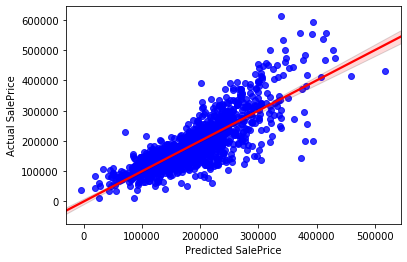

In [46]:
# Total_Living_SF was chosen as the baseline model predictor, as it has highest correlation to SalePrice
model1 = lr_model_train(features=['Total_Living_SF'])

- *The baseline SLR model with 'Total_Living_SF' as the predictor*
- *The R^2 score is 0.68*

### Model 2: Linear Regression w/ Multiple predictor variables (MLR) w/ 4 predictors

[116328.27088341 122597.70809405 205572.35754141 ...  85458.97174799
 154702.94989171 302533.80137021]
Model RSquared score: 0.8431238358613148
Model adj. RSquared score: 0.8428326053585821
RMSE: 31330.379567416643


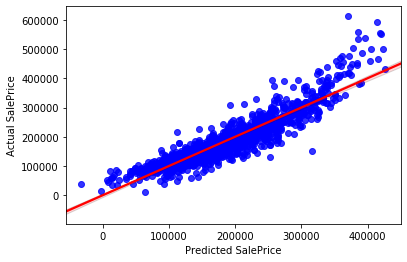

In [47]:
# Picked 4 predictor variables according to strength of correlation to SalePrice (based on heatmap)
model2 = lr_model_train(features=['Overall Qual', 'Total_Living_SF', 'Garage Area', 'Neighborhood_MedianPrice'])

In [48]:
# Calculate change in RMSE from baseline model to Model 2
(44860-31330)/44860

0.3016049933125279

- *Increasing the number of predictor variables increased the adjusted R^2 score quite significantly*
- *It also reduced the root mean square error (RMSE) by around 30% from baseline model*

### Model 3: MLR w/ 5 predictors

[111464.54303009 118135.08947547 204757.94947365 ...  81933.3390245
 156097.81286465 301786.10523869]
Model RSquared score: 0.8447841257704712
Model adj. RSquared score: 0.8443996901686643
RMSE: 31164.146929130042


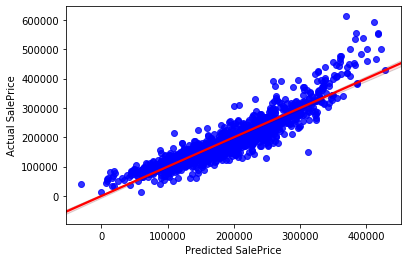

In [49]:
model3 = lr_model_train(features=['Overall Qual', 'Total_Living_SF', 'Garage Area', 'Neighborhood_MedianPrice', 'Year Built'])

- *Increasing the number of predictors at this point does not seem to increase the R2 score/reduce RMSE significantly*
- *Therefore, it was decided to keep the positively correlated predictors as the ones in this model. The rest were excluded.*

### Model 4: MLR w/ 5 +ve corr predictors, 1 -ve corr predictor

- *So far, predictor variables were picked based on the highest positive correlation strength.*
- *However, predictor variables with negative correlation are important too.*
- *Model 4 was tested with a  variable with the strongest negative correlation strength.*

[114386.71190473 121982.55900822 198432.47350105 ...  86044.61182377
 159380.22489268 299175.28869685]
Model RSquared score: 0.8510593320730134
Model adj. RSquared score: 0.8505979297560153
RMSE: 30527.681650817027


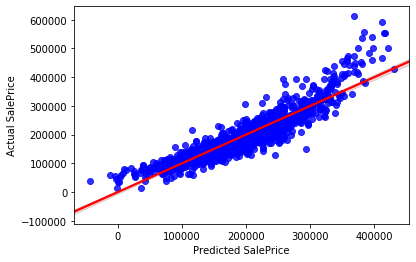

In [50]:
model4 = lr_model_train(features=['Overall Qual', 'Total_Living_SF', 'Garage Area', 'Neighborhood_MedianPrice', 'Year Built',
                  'Overall Cond'])

In [51]:
# Calculate change in RMSE from baseline model to Model 4
(44860-30528)/44860

0.31948283548818546

- *There is a slight increase in the reduction of RMSE from Model 3 to Model 4*
- *32% reduction in RMSE compared to baseline model*

### Model 5: Model 4 + Interaction predictor

- *Apart from individual predictors, inclusion of interaction predictors might be a good idea*
- *Overall Quality **and** Total Living SF (2 of the most strongly correlated variables to SalePrice) will be combined to form an interaction predictor*

[111289.96456449 117209.23473079 189510.98485747 ...  98479.11354924
 155025.86838069 306961.22492673]
Model RSquared score: 0.8955044368918674
Model adj. RSquared score: 0.8951157367191156
RMSE: 25570.31634128331


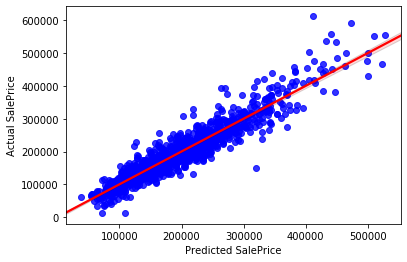

In [52]:
model5 = lr_model_train(features=['Overall Qual', 'Total_Living_SF', 'Garage Area', 'Neighborhood_MedianPrice', 'Year Built',
                                  'Overall Cond', 'Interaction_Overall Qual_Total Living SF'])

In [53]:
# Calculate change in RMSE from baseline model to Model 4
(44860-25570)/44860

0.43000445831475703

- *An addition of an interaction predictor (Overall Qual interaction with Total Living SF) resulted in a marked improvement in score*
- *The RMSE also reduced by approx. 43% from baseline model*

### Model 6: Model 4 + associated combination of interactions

- *Model 5 has only 1 interaction predictor*
- *Model 6 will test if adding all the associated combinations of interaction predictors will improve performance of training model or not*
- As there is a risk of overfitting, cross-validation will be performed before choosing a model.

In [54]:
# Define features (same as Model 4)
poly_features = ['Overall Qual', 'Total_Living_SF', 'Neighborhood_MedianPrice','Garage Area', 'Year Built', 'Overall Cond']

# Subset train dataframe and assign to X
X = training_set[poly_features]

# Create a new dataframe (X_poly) with the features + associated combination of interactions
poly = PolynomialFeatures(include_bias=False) 
X_training_poly = poly.fit_transform(X)
X_training_poly = pd.DataFrame(X_training_poly, columns=poly.get_feature_names(poly_features))

In [55]:
X_training_poly.head()

,Overall Qual,Total_Living_SF,Neighborhood_MedianPrice,Garage Area,Year Built,Overall Cond,Overall Qual^2,Overall Qual Total_Living_SF,Overall Qual Neighborhood_MedianPrice,Overall Qual Garage Area,Overall Qual Year Built,Overall Qual Overall Cond,Total_Living_SF^2,Total_Living_SF Neighborhood_MedianPrice,Total_Living_SF Garage Area,Total_Living_SF Year Built,Total_Living_SF Overall Cond,Neighborhood_MedianPrice^2,Neighborhood_MedianPrice Garage Area,Neighborhood_MedianPrice Year Built,Neighborhood_MedianPrice Overall Cond,Garage Area^2,Garage Area Year Built,Garage Area Overall Cond,Year Built^2,Year Built Overall Cond,Overall Cond^2
0,-0.077403,-0.983040,-0.820069,-1.364608,-1.534329,1.313316,0.005991,0.076090,0.063476,0.105625,0.118761,-0.101654,0.966367,0.806160,1.341464,1.508306,-1.291042,0.672513,1.119073,1.258256,-1.077010,1.862156,2.093758,-1.792162,2.354166,-2.015059,1.724798
1,-0.781856,-0.024575,-0.951256,-2.205734,-2.066923,1.313316,0.611299,0.019214,0.743745,1.724566,1.616035,-1.026824,0.000604,0.023377,0.054205,0.050794,-0.032274,0.904887,2.098217,1.966171,-1.249299,4.865262,4.559081,-2.896825,4.272169,-2.714522,1.724798
2,1.331503,-0.086565,-0.104892,0.055960,0.196599,-0.511360,1.772901,-0.115261,-0.139664,0.074510,0.261773,-0.680877,0.007493,0.009080,-0.004844,-0.017019,0.044266,0.011002,-0.005870,-0.020622,0.053637,0.003131,0.011002,-0.028616,0.038651,-0.100533,0.261489
3,0.627050,0.888590,-0.935175,1.084002,-2.732664,2.225653,0.393192,0.557190,-0.586401,0.679724,-1.713517,1.395596,0.789592,-0.830987,0.963233,-2.428218,1.977693,0.874552,-1.013731,2.555518,-2.081375,1.175061,-2.962214,2.412613,7.467454,-6.081964,4.953533
4,-0.781856,-0.530034,-0.612710,-0.537501,-0.735439,-2.336035,0.611299,0.414410,0.479051,0.420249,0.575007,1.826443,0.280936,0.324757,0.284894,0.389808,1.238178,0.375413,0.329332,0.450611,1.431312,0.288908,0.395299,1.255622,0.540871,1.718012,5.457060


In [56]:
# Number of predictor variables
print('Number of predictor variables:', len(X_training_poly.columns))

Number of predictor variables: 27


#### Cross-validation for poly-features 

In [57]:
lr_scores = cross_val_score(lr, X_training_poly, training_set['SalePrice'], cv=10)
lr_scores.mean()

0.8924483613553816

In [58]:
ridge_scores = cross_val_score(ridge, X_training_poly, training_set['SalePrice'], cv=10)
ridge_scores.mean()

0.8925972916746708

In [59]:
lasso_scores = cross_val_score(lasso, X_training_poly, training_set['SalePrice'], cv=10)
lasso_scores.mean()

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarni

0.8930865927270218

- Performance between the 3 models seem very similar.
- Therefore, all 3 models will be constructed to use on the testing set.

#### Linear Regression

[115312.86638023 121931.16625267 191995.04735521 ...  99896.65704555
 153938.77942716 315616.71952394]
Model RSquared score: 0.9025971357338789
Model adj. RSquared score: 0.9010073840258317
RMSE: 24687.26845142923


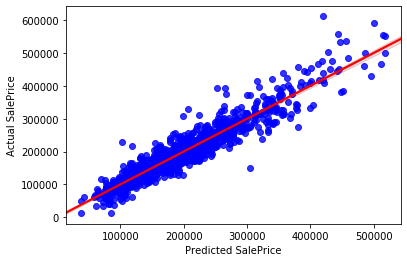

In [60]:
model6 = lr_model_train(df=X_training_poly, features=X_training_poly.columns)

- *Creating a new dataframe with the 6 predictors and the associated combination of interactions improved the model's performance, as seen from the improved adjusted R^2 score compared to the previous models.*

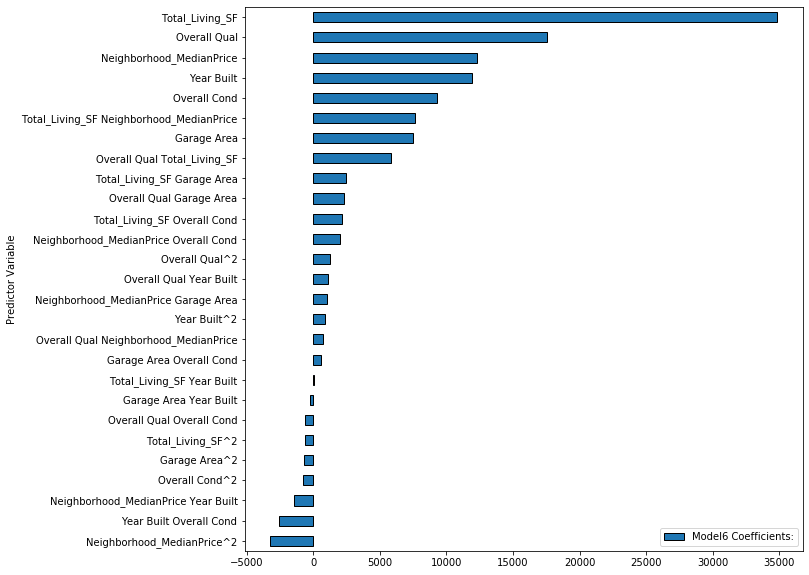

In [61]:
# Visualise the coefficients from the linear regression model
lr_df = pd.DataFrame({'Predictor Variable': X_training_poly.columns,
              'Model6 Coefficients:': model6.coef_})
lr_df.set_index('Predictor Variable', inplace=True)
lr_df.sort_values(by='Model6 Coefficients:').plot(kind='barh', figsize=(10,10))

- It turns out that the coefficient for Overall Cond is a positive value after all.
    - This means that as the rating increases (i.e. gets better), the value of the house increases.
    - This is not what the scatterplot of Overall Cond vs. SalePrice suggested.
- The interaction between Total_Living_SF and Neighborhood_MedianPrice seems to be quite an influential factor on SalePrice

#### Ridge Regularization

- Ridge regularization was done on the predictor variables used in Model 6 in case overfitting has occurred.

In [62]:
def ridge_model_train(df=X_training_poly, features=X_training_poly.columns): # takes the dataframe, and the features list
    X = df.loc[:, features] # Subsets the dataframe to only include the features in the list, and assign to X
    y = training_set['SalePrice']  # the target variable y is the SalePrice

    # Model using RidgeCV
    alphas = np.logspace(0, 5, 200)
    model = RidgeCV(alphas=alphas, store_cv_values=False)
    model = model.fit(X, y)
    # Find the optimal alpha and use it
    optimal_alpha = model.alpha_
    model_opt = Ridge(alpha=optimal_alpha)
    # Fit the optimized model
    model_opt.fit(X, y)
    score = model_opt.score(X, y)
    predictions = model_opt.predict(X)
    print("Model RSquared score:", score)
    print("Model adj. RSquared score:", 1-((1-score)*((len(y)-1)/(len(y)-(len(features))))))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y, predictions)))

    # Plot the predictions vs. the actual values for the target variable
    sns.regplot(predictions, y, line_kws={'color':'red'}, scatter_kws={'color':'blue'})
    ax = plt.gca()
    ax.set_xlabel('Predicted SalePrice')
    ax.set_ylabel('Actual SalePrice')
    
    # Return optimized model
    return model_opt

Model RSquared score: 0.9022824309902828
Model adj. RSquared score: 0.9006875428582974
RMSE: 24727.11807582368


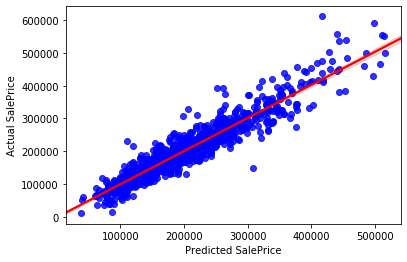

In [63]:
ridge_model = ridge_model_train()

- The R2 score and RMSE for the Ridge model seems to be negligibly different from Model 6.

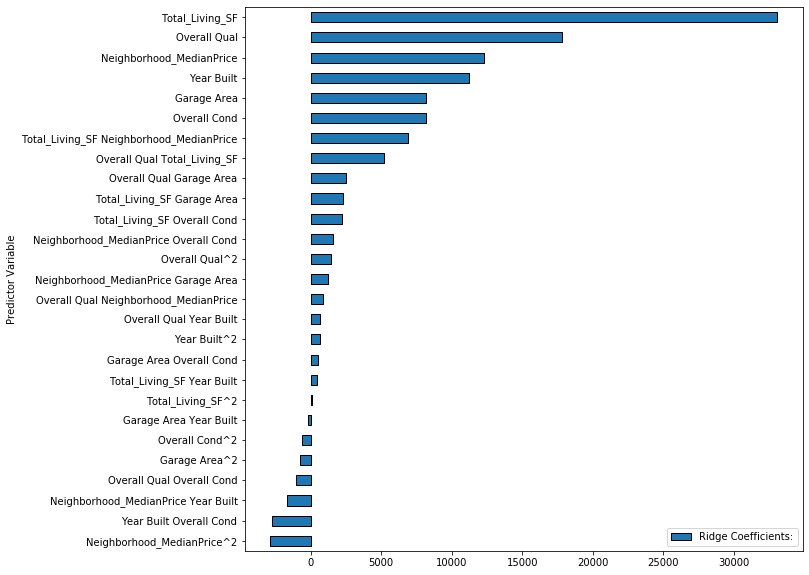

In [64]:
# Visualise the coefficients from the ridge model
ridge_df = pd.DataFrame({'Predictor Variable': X_training_poly.columns,
              'Ridge Coefficients:': ridge_model.coef_})
ridge_df.set_index('Predictor Variable', inplace=True)
ridge_df.sort_values(by='Ridge Coefficients:').plot(kind='barh', figsize=(10,10))

- From the plot of the Ridge coefficients above, it can be seen that:
    - The strongest predictor is still Total_Living_SF
    - The strongest interaction predictor is that between Total_Living_SF and Neighborhood_MedianPrice

#### Lasso Regularization

In [65]:
def lasso_model_train(df=X_training_poly, features=X_training_poly.columns): # takes the dataframe, and the features list
    X = df.loc[:, features] # Subsets the dataframe to only include the features in the list, and assign to X
    y = training_set['SalePrice']  # the target variable y is the SalePrice

    # Model using Lasso
    model = LassoCV(n_alphas=200)
    model = model.fit(X, y)
    # Find optimal alpha value and use that value
    optimal_alpha = model.alpha_
    model_opt = Lasso(alpha=optimal_alpha)
    # Fit the model and score it
    model_opt.fit(X, y)
    score = model_opt.score(X, y)
    # Use it to predict using the training set
    predictions = model_opt.predict(X)
    print("Model RSquared score:", score)
    print("Model adj. RSquared score:", 1-((1-score)*((len(y)-1)/(len(y)-(len(features))))))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y, predictions)))

    # Plot the predictions vs. the actual values for the target variable
    sns.regplot(predictions, y, line_kws={'color':'red'}, scatter_kws={'color':'blue'})
    ax = plt.gca()
    ax.set_xlabel('Predicted SalePrice')
    ax.set_ylabel('Actual SalePrice')
    
    # Return the optimized model
    return model_opt

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model RSquared score: 0.901209667698194
Model adj. RSquared score: 0.8995972705608136
RMSE: 24862.47724850179


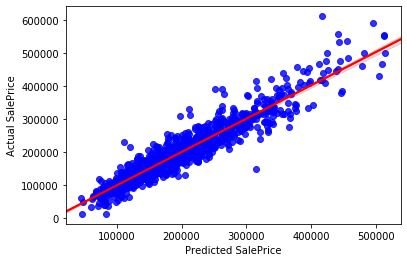

In [66]:
lasso_model = lasso_model_train()

- Adjusted R2 score is actually slightly lower for Lasso compared to Linear Regression and Ridge.

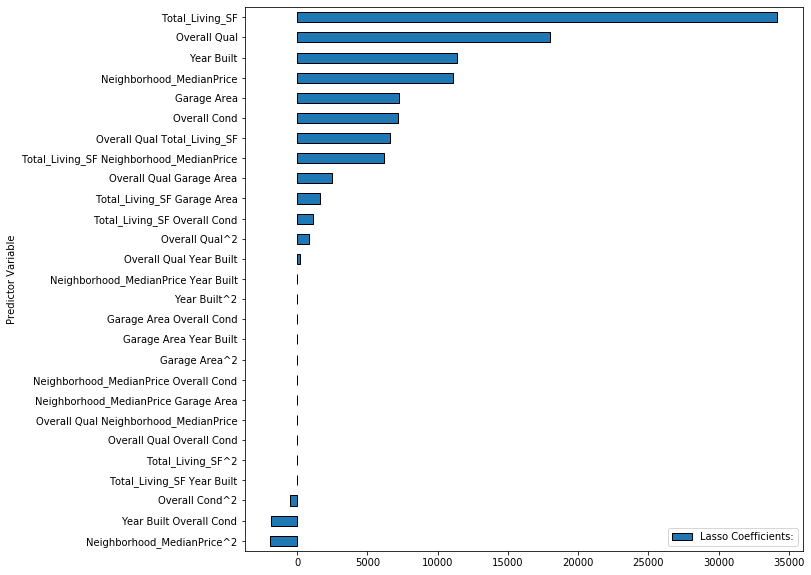

In [67]:
# Plot Lasso coefficients
lasso_df = pd.DataFrame({'Predictor Variable': X_training_poly.columns,
              'Lasso Coefficients:': lasso_model.coef_})
lasso_df.set_index('Predictor Variable', inplace=True)
lasso_df.sort_values(by='Lasso Coefficients:').plot(kind='barh', figsize=(10,10))

# Model Evaluation on testing set

- 3 tests will be done:
    - Test 1: Testing performance of Model 6
    - Test 2: Testing performance of Ridge regularization performed on same variables as Model 6
    - Test 3: Same as Test 2, except Lasso used instead of Ridge

In [68]:
# Scale all columns in testing_set using z-score
scaler(testing_set)

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [69]:
# Create poly features dataframe using testing_set (using same features as Model 6)
Xtesting = testing_set[poly_features]
poly = PolynomialFeatures(include_bias=False) 
Xtesting_poly = poly.fit_transform(Xtesting)
Xtesting_poly = pd.DataFrame(Xtesting_poly, columns=poly.get_feature_names(features))

### Test 1 - Model 6 Linear Regression 

In [70]:
# Use the best model to get predictions from the Xtest_poly dataframe
test1_predictions = model6.predict(Xtesting_poly)
#test1_predictions = pd.Series(test1_predictions)
#test1 = pd.concat([y_test, test1_predictions], axis=1, join='outer')
print('Model6 test R2 score:', model6.score(Xtesting_poly, testing_set['SalePrice']))
print('Model6 RMSE:', np.sqrt(metrics.mean_squared_error(testing_set['SalePrice'], test1_predictions)))

Model6 test R2 score: 0.892453475430448
Model6 RMSE: 26010.056663679745


- The model's performance on the testing set closely resembles that of the training set:

|Metric|Training set|Testing set|
|---|---|---|
|R2|0.90|0.89|
|RMSE|24687|26010|

- This suggests that the model has not been overfitted to an unacceptable degree
- Thus, it is likely able to generalize to unseen data
- Ability to generalize will be seen by testing the model on test.csv

### Test 2 - Ridge model using same predictors as Model 6

In [71]:
# Use the best model to get predictions from the Xtest_poly dataframe
test2_predictions = ridge_model.predict(Xtesting_poly)
#test2_predictions = pd.Series(test2_predictions, name='predicted_SalePrice')
#test2 = pd.concat([X_test['SalePrice'], test2_predictions], axis=1)
print('Model6 test R2 score:', ridge_model.score(Xtesting_poly, testing_set['SalePrice']))
print('Model6 RMSE:', np.sqrt(metrics.mean_squared_error(testing_set['SalePrice'], test2_predictions)))

Model6 test R2 score: 0.8931076008590393
Model6 RMSE: 25930.83611640289


- Using Ridge, performance of the model improved negligibly compared to Test 1.

### Test 3 - Lasso model using same predictors as Model 6

In [72]:
# Use the best model to get predictions from the Xtest_poly dataframe
test3_predictions = lasso_model.predict(Xtesting_poly)
#test2_predictions = pd.Series(test2_predictions, name='predicted_SalePrice')
#test2 = pd.concat([X_test['SalePrice'], test2_predictions], axis=1)
print('Model6 test R2 score:', lasso_model.score(Xtesting_poly, testing_set['SalePrice']))
print('Model6 RMSE:', np.sqrt(metrics.mean_squared_error(testing_set['SalePrice'], test3_predictions)))

Model6 test R2 score: 0.8910795715715919
Model6 RMSE: 26175.668296283075


- Using Lasso, performance of the model is actually slightly worse compared to Test 1 and 2.

# Model Prediction on actual test.csv

- Linear regression (Model 6) will be used to make predictions as it seems to be able to generalize well to unseen data without having to introduce a penalty to the loss function.

In [73]:
# Scale predictor variables in test.csv
scaler(test)

In [74]:
# Create poly features dataframe using testing_set (using same features as Model 6)
Xtest = test[poly_features]
poly = PolynomialFeatures(include_bias=False) 
Xtest_poly = poly.fit_transform(Xtest)
Xtest_poly = pd.DataFrame(Xtest_poly, columns=poly.get_feature_names(features))

In [75]:
# Create a dataframe in the format required by Kaggle
# Generate predictions based on the Xtest_poly dataframe
test_predictions = model6.predict(Xtest_poly)

# Convert the predictions to a series with column name SalePrice
test_predictions = pd.DataFrame(data=test_predictions, columns=['SalePrice'])

# Concatenate the test_predictions to the test df
test = pd.concat([test, test_predictions], axis=1)

# Subset the test df to give test_final_predictions with Id and SalePrice cols
test_final_predictions = test[['Id', 'SalePrice']]

# Set index to be the Id col
test_final_predictions.set_index(keys=['Id'], inplace=True)

In [76]:
# Save test_final_predictions as a csv file for Kaggle submission
test_final_predictions.to_csv('../datasets/test_final_predictions.csv')

(-0.5, 1176.5, 145.5, -0.5)

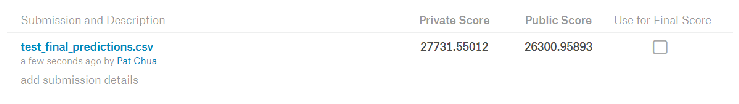

In [77]:
# Kaggle score
plt.figure(figsize=(13,13))
plt.imshow(mpimg.imread('../images/Kaggle score.png'))
plt.axis('off')

- As RMSE between the (train.csv) testing set and the test.csv are pretty much identical, it can be said that the selected model generalizes well to unseen data.

# Conclusion

- SalePrice depends strongly on the following features:
    - The size of the living area of the house
    - The quality of the house
    - The condition of the house
    - Which neighborhood the house is located in
    - The garage size
    - To a lesser extent, the year the house was in (i.e. the age of the house)

- The interaction between the features mentioned above is also something that plays an important part in predicting SalePrice
    - From Ridge and Lasso coefficients, it can be seen that the interaction of Neighborhood and the size of the house is one of the more important factor to consider.